Monocular attempt 1

In [7]:
import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time



import json


## Some helper functions are used from the original implementation
from utils import *
from kitti_utils import *
from depthDecoder import *
from pose_decoder import *
from layers import *


import datasets
import networks
from IPython import embed


cuda = torch.cuda.is_available()
cuda

True

In [8]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [9]:
## Load the data according to files listed in eigen_full split 

dataset = datasets.KITTIRAWDataset 
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_zhou/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_zhou/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [10]:
## Size to rescale all input images to
height = 192
width = 640

## Scales of the output image from each layer of the decoder
## output scale = input scale/2**(n) for n in scales
scales = np.arange(4)

img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")

## List of frames that the dataloader must return 
## 0 - present frame
frame_ids = [0,1,-1]



weights_pretrained = True

num_scales = len(scales)
num_input_frames = len(frame_ids)

learning_rate = 0.0001

In [11]:
batch_size = 16
num_workers = 10

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

In [12]:
class DepthEncoderModule(nn.Module):
    def __init__(self, layers, num_input_images = 1):
        super(DepthEncoderModule, self).__init__()
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        pretrained = True
        self.encoder = models.resnet18(pretrained)

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))
    
        return self.features

In [13]:
class PoseEncoderModule(nn.Module):
    def __init__(self, layers, num_input_images = 1):
        super(PoseEncoderModule, self).__init__()
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        pretrained = True
        self.encoder = models.resnet18(pretrained)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.conv1(x)
        x = self.bn1(x)
        self.features.append(self.relu(x))
        self.features.append(self.encoder.layer1(self.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))
    
        return self.features

In [14]:
num_layer = 18

params = []

## Initialize the models

# encoder = networks.ResnetEncoder(num_layer, weights_pretrained)
encoder = DepthEncoderModule(layers = 18)
params += list(encoder.parameters())


# decoder = networks.DepthDecoder(encoder.num_ch_enc, scales)
decoder = Decoder(encoder.num_ch_enc, scales)
params += list(decoder.parameters())

num_input_images = 2
# pose_enc = networks.ResnetEncoder(num_layer, weights_pretrained,num_input_images=2)
pose_enc = PoseEncoderModule(layers = 18, num_input_images=num_input_images)

pose_enc.conv1 = nn.Conv2d(num_input_images*3, 64, kernel_size=7, stride=2, padding=3, bias=False)
pose_enc.maxpool =  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
pose_enc.bn1 = nn.BatchNorm2d(64)
pose_enc.relu = nn.ReLU(inplace=True)

loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(18)])
new_weights = torch.cat([loaded['conv1.weight']] * num_input_images, 1) / num_input_images
pose_enc.conv1.weight = torch.nn.Parameter(new_weights)

params += list(pose_enc.parameters())

# pose_dec = networks.PoseDecoder(pose_enc.num_ch_enc,num_input_features=1,
#                     num_frames_to_predict_for=2)
pose_dec = PoseDecoder(pose_enc.num_ch_enc, num_input_features=1, num_frames_to_predict_for=2)
params += list(pose_dec.parameters())



ssim = SSIM()
ssim.to(device)

encoder.to(device)
decoder.to(device)
pose_enc.to(device)
pose_dec.to(device)

optimizer = optim.Adam(params, learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


In [15]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
#print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

In [16]:

def generate_images_pred(inputs, outputs):
        
   
    source_scale = 0
    
    for scale in scales:
        disp = outputs[("disp", scale)]

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        outputs[("depth", 0, scale)] = depth
    
        for frame_id in frame_ids[1:]:
            T = outputs[("pred_pose",0,frame_id)]

            cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
            pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)

            outputs[("color",frame_id, scale)] = F.grid_sample(inputs[("color",frame_id, source_scale)],
                pix_coords,padding_mode="border",align_corners=False)
            
            
            outputs[("color_identity",frame_id,scale)] = inputs[("color",frame_id,source_scale)]

    return outputs   


In [17]:
def predict_poses(inputs,features):

    outputs = {}
    pose_features = {i:inputs["color_aug", i, 0] for i in frame_ids}
    for frame_id in frame_ids:
        if frame_id < 0:
            pose_inputs = [pose_features[frame_id],pose_features[0]]
        else:
            pose_inputs = [pose_features[0],pose_features[frame_id]]
    
        pose_inputs = [pose_enc(torch.cat(pose_inputs,1))]

        axisangle,translation = pose_dec(pose_inputs)
        
        outputs[("axisangle",0,frame_id)] = axisangle
        outputs[("translation",0,frame_id)] = translation
        
        outputs[("pred_pose", 0, frame_id)] = transformation_from_parameters(
                        axisangle[:, 0], translation[:, 0], invert=(frame_id < 0))
    return outputs

In [18]:
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)*2/float(2*sigma*2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim_new(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

In [19]:

def compute_reprojection_loss(pred, target):
    l1_loss = (torch.abs(target - pred)).mean(1,True)
    ssim_loss = torch.clamp((1 - ssim_new(pred, target,1)) * 0.5, 0, 1) #torch.clamp(ssim_new(pred, target)).mean(1, True)
    #alpha = 0.95
    #reprojection_loss = (alpha)*ssim_loss + (1-alpha) * l1_loss
#     reprojection_loss = 1e-2*ssim_loss + 0.15* l1_loss + 0.85*ssim(pred, target).mean(1, True)
    reprojection_loss = 0.15* l1_loss + 0.85*ssim(pred, target).mean(1, True)
    return reprojection_loss


#         l1_loss = (torch.abs(target - pred)).mean(1,True)
        
#         ssim_loss = ssim(pred, target).mean(1, True)
#         reprojection_loss = 0.85*ssim_loss + 0.15 * l1_loss

#         return reprojection_loss


In [20]:
def get_smooth_loss(disp, img):

    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


In [21]:

def compute_losses(inputs, outputs):

        losses = {}
        total_loss = 0
        

        for scale in scales:
            loss = 0
            reprojection_losses = []

            source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in frame_ids[1:]:
                pred = outputs[("color", frame_id, scale)]
                reprojection_losses.append(compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)
            
            
            #For automasking, find the pixels where the unwarped reprojection loss is less than warped
            identity_reproj_loss = []
            
            for frame_id in frame_ids[1:]:
                pred = inputs[("color",frame_id,source_scale)]
                identity_reproj_loss.append(compute_reprojection_loss(pred,target))
                
            identity_reproj_loss = torch.cat(identity_reproj_loss, 1)
                
                
            identity_reproj_loss += torch.randn(identity_reproj_loss.shape).cuda() *1e-5
            
            
            reprojection_losses = torch.cat((identity_reproj_loss, reprojection_losses), dim=1)
 
        
            to_optimise, idxs = torch.min(reprojection_losses, dim=1)
            #to_optimise = reprojection_losses
            
            outputs["identity_selection/{}".format(scale)] = (idxs > identity_reproj_loss.shape[1]-1).float()
            
            
            loss = loss + to_optimise.mean()

            norm_disp = disp / (disp.mean(2, True).mean(3, True)+ 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

#             loss =  loss + ((1e-5)*smooth_loss) / (2 ** scale)
            loss =  loss + (1e-3)*(smooth_loss) / (2 ** scale)
            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

        total_loss = total_loss/num_scales
        losses["loss"] = total_loss
        return losses



In [22]:

def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs[("depth", 0, 0)]
        
        #Resize and clamp the values from 1e-3 to 80
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [23]:
def train(encoder,decoder,train_loader,val_loader,num_epochs):
              
        encoder.train()
        decoder.train()
        
        for epoch in range(0, num_epochs):
#             lr_scheduler.step()
            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)
            print('epoch')

            for batch_idx, inputs in enumerate(train_loader):

                outer.update(1)
                optimizer.zero_grad()


                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
                                
                outputs.update(predict_poses(inputs,features))
                       
                outputs = generate_images_pred(inputs, outputs)
                
                losses = compute_losses(inputs, outputs)
                total_loss = total_loss + losses['loss'].item()
                
                losses["loss"].backward()
                optimizer.step()
                lr_scheduler.step()

                del inputs, outputs, features
                if batch_idx%1000==0 and batch_idx>0:
                    print('Batch No: ',batch_idx)
                    #print('Loss: ',total_loss/(batch_idx+1))
                    print('Loss: ',losses["loss"].cpu().data)
                del losses
                    
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(encoder,decoder,val_loader)
            run_images(epoch)

In [24]:
def validation(encoder,decoder,val_loader):
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        total_loss = 0
        metrics = np.zeros((7))
        for batch_idx, inputs in enumerate(val_loader):

            before_op_time = time.time()

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            features = encoder(inputs["color_aug", 0, 0])
            outputs = decoder(features)
            
            outputs.update(predict_poses(inputs,features))
            outputs = generate_images_pred(inputs, outputs)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses,features
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [25]:
folder_name = 'ModifiedLoss'

In [26]:
def saveModel(epoch_num):
    torch.save(encoder,'MonocularOutput/Models/Resnet18/'+folder_name+'/DepthEncoder_'+str(epoch_num)+'.pt')
    torch.save(decoder,'MonocularOutput/Models/Resnet18/'+folder_name+'/DepthDecoder_'+str(epoch_num)+'.pt')
    torch.save(pose_enc,'MonocularOutput/Models/Resnet18/'+folder_name+'/PoseEncoder_'+str(epoch_num)+'.pt')
    torch.save(pose_dec,'MonocularOutput/Models/Resnet18/'+folder_name+'/PoseDecoder_'+str(epoch_num)+'.pt')

In [27]:
def run_images(epoch_num):
    directory = 'Iteration '+str(epoch_num)+'/'
    parent_dir = 'MonocularOutput/Resnet18/'+folder_name+'/'
    path = os.path.join(parent_dir, directory) 
    os.mkdir(path) 
    image_output_path = parent_dir+directory
    for i in range(1, 9):
        image_name = 'Test'+str(i)+'.jpg'
        image_path = '/home/ubuntu/monodepth2/assets/'+image_name
        input_image = pil.open(image_path).convert('RGB')
        original_width, original_height = input_image.size
        input_image_resized = input_image.resize((width, height), pil.LANCZOS)
        input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

        with torch.no_grad():
            encoder.eval()
            decoder.eval()
            features = encoder(input_image_pytorch.to(device))
            outputs = decoder(features)

        disp = outputs[("disp", 0)]
        disp_resized = torch.nn.functional.interpolate(disp,(original_height, original_width), mode="bilinear", align_corners=True)

        # Saving colormapped depth image
        disp_resized_np = disp_resized.squeeze().cpu().numpy()
        vmax = np.percentile(disp_resized_np, 95)

        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.imshow(input_image)
        plt.title("Input", fontsize=22)
        plt.axis('off')

        plt.subplot(212)
        plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
        plt.title("Disparity prediction", fontsize=22)
        plt.axis('off')
        plt.savefig(image_output_path+image_name,dpi = 100)
    saveModel(epoch_num)

Training Epoch:   0%|          | 0/2488 [00:00<?, ?it/s]

epoch


Training Epoch:  40%|████      | 1002/2488 [25:18<37:33,  1.52s/it] 

Batch No:  1000
Loss:  tensor(0.1570)


Training Epoch:  80%|████████  | 2002/2488 [50:16<12:01,  1.49s/it]

Batch No:  2000
Loss:  tensor(0.1450)


Training Epoch: 100%|██████████| 2488/2488 [1:02:22<00:00,  1.31s/it]

Train Loss at Epoch_1: 0.15029631147813952
Total Loss (Validation):  0.15062834770567174
Error Metrics:  [ 0.48144002  4.96399889 12.17975641  0.61800223  0.2763153   0.53289062
  0.75898178]


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DepthEncoderModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type PoseEncoderModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
Training Epoch:   0%|          | 0/2488 [00:00<?, ?it/s]

epoch


Training Epoch:   5%|▍         | 119/2488 [03:16<58:01,  1.47s/it]  

KeyboardInterrupt: 

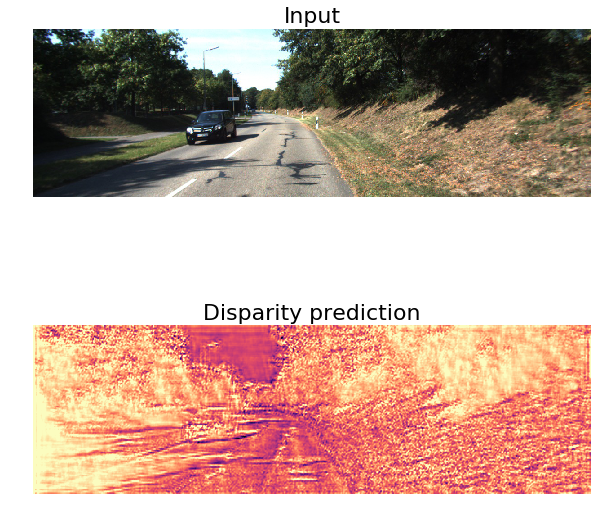

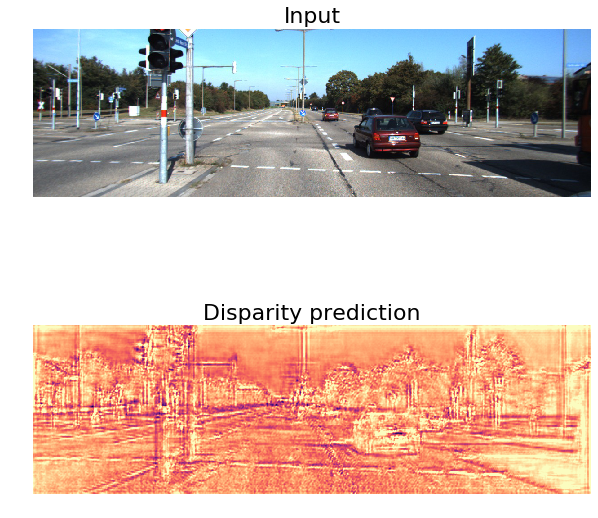

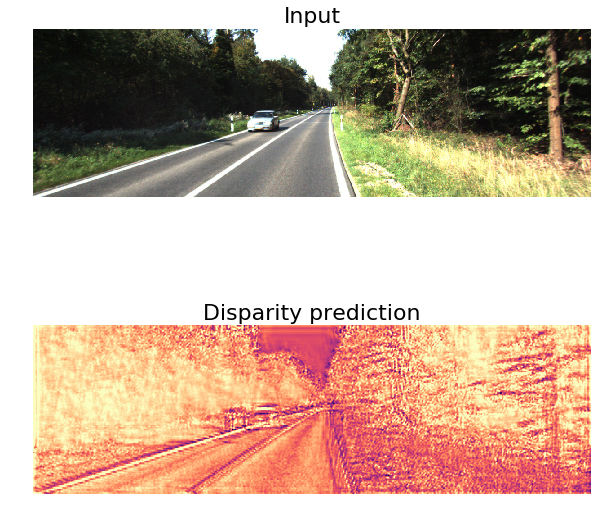

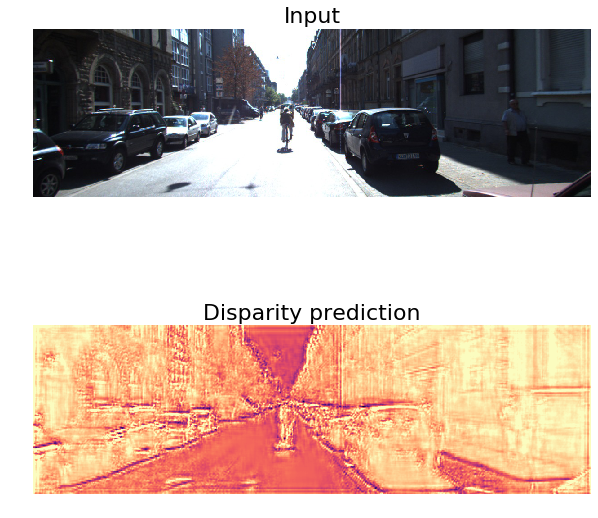

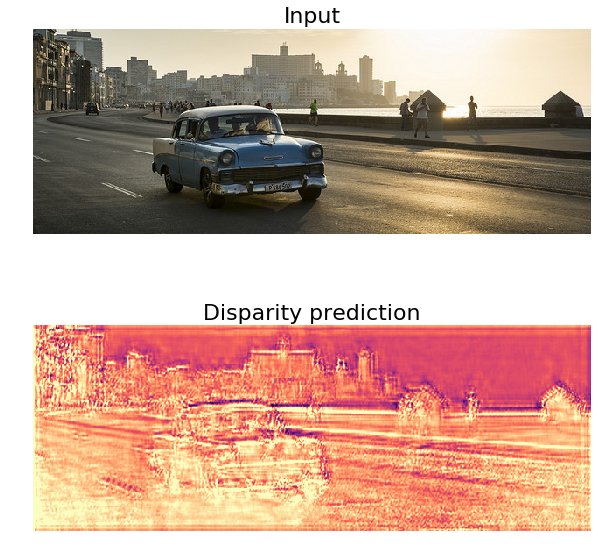

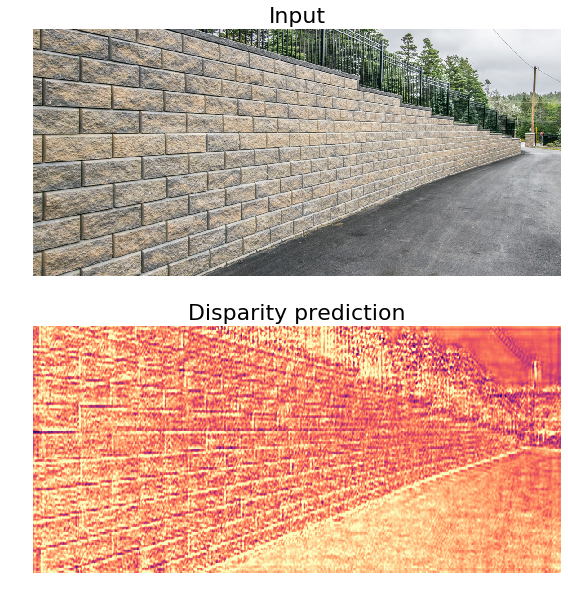

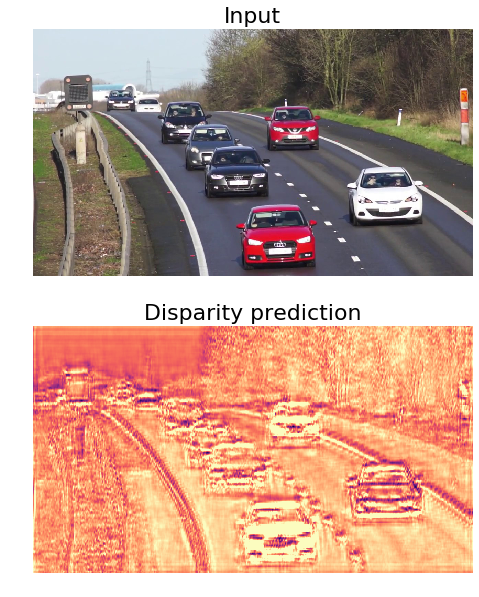

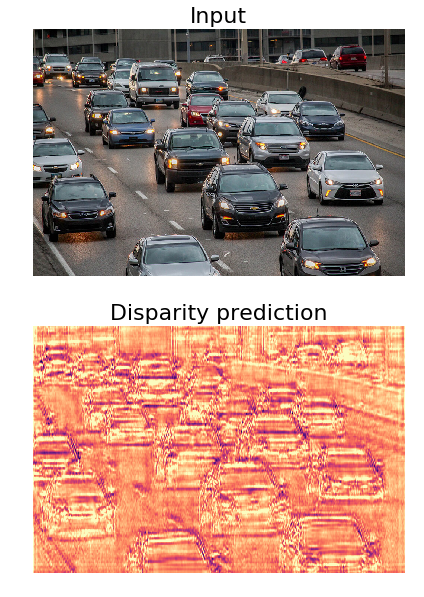

In [28]:
num_epochs = 6
train(encoder,decoder,train_loader,val_loader,num_epochs)
#     run_images(epoch_num)

In [ ]:
i = 0
total_loss = 0
train_loader = val_loader
for batch_idx, inputs in enumerate(train_loader):
                optimizer.zero_grad()

                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(device)

                features = encoder(inputs["color_aug", 0, 0])
                outputs = decoder(features)
                
                outputs.update(predict_poses(inputs,features))
               
                o1 = generate_images_pred(inputs, outputs)
                
                
                losses = compute_losses(inputs, o1)
                
                total_loss = total_loss + losses['loss'].item()
                optimizer.zero_grad()
                losses["loss"].backward()
                optimizer.step()
                i = i+1
                
                lr_scheduler.step()
                
                if i>2:
                    break
                   
                del inputs, outputs, losses,features,o1
                

In [ ]:
outputs[('disp', 3)]

In [ ]:
image_path = "/home/ubuntu/monodepth2/assets/Home_Hero5.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [ ]:
a = val_dataset[0][('color_aug', 's', 0)]
b = val_dataset[0][('color', 0, 0)]

In [ ]:
class ss(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(ss, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


In [ ]:
s = ss()

In [ ]:
validation(encoder,decoder,val_loader)

In [ ]:
import os

test_path = "/home/ubuntu/monodepth2/kitti_data"

ftest = "/home/ubuntu/monodepth2/splits/eigen/test_files.txt"
test_filenames = open(ftest).readlines()


for f in test_filenames:
    path = f.split(" ")
    
    
    if path[2]=='l\n':
        image_path = os.path.join(test_path,path[0],"image_03/data",path[1])
    else:
        image_path = os.path.join(test_path,path[0],"image_04/data",path[1])
    print(image_path)
    input_image = pil.open(image_path+".jpg").convert('RGB')
    original_width, original_height = input_image.size
    input_image_resized = input_image.resize((width, height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        features = encoder(input_image_pytorch.to(device))
        outputs = decoder(features)

    disp = outputs[("disp", 0)]
    disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off');
    
    plt.savefig('output_imgs_10epochs/'+path[1]+'.png',dpi = 100)
    
    plt.close('all')
    del outputs,features



In [ ]:
image_path = "/home/ubuntu/monodepth2/assets/test_image.jpg"
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [ ]:
encoder = torch.load('encoder10e.pt')
decoder = torch.load('decoder10e.pt')

In [ ]:
train_dataset[0][('color',0,2)].shape

In [ ]:
!nvidia-smi

In [ ]:
image_name ='IMG_20200428_191113.jpg'
image_path = '/home/ubuntu/monodepth2/assets/'+image_name
input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

with torch.no_grad():
    encoder.eval()
    decoder.eval()
    features = encoder(input_image_pytorch.to(device))
    outputs = decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp,(original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off')

In [ ]:
run_images(0)

In [ ]:
run_images(6)